In [1]:
###--- import packages ---###

import numpy as np
import matplotlib.pyplot as plt
from PDE_FIND import *
import pandas as pd
import pickle
import matplotlib 
font = {'family': 'Arial'}
matplotlib.rc('font', **font)
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import scipy.signal

In [6]:
###--- import data---###

T = [35,45,55,65,75,85]
DecData = pickle.load(open("data/ExperimentalData-LowVar",'rb'))
red = DecData['red']
time = DecData['time']

# converting all the colour vectors to same length - all samples
redl = []
for i in range(len(red)):
    redl_i = []
    for j in range(len(red[T[i]])):
        redl_i.append(np.concatenate((red[T[i]][j], np.ones(len(time)-len(red[T[i]][j]))*red[T[i]][j][-1])))
    redl.append(np.array(redl_i))
redl = np.array(redl)

# averaging over all samples for each temperature condition
rm = {}
for i in range(len(DecData['red'])):
    rm[T[i]] = np.mean(DecData['red'][T[i]],axis=0)

    
# converting red colour vectors to same length - average
rml = []
for i in range(len(rm)):
    rml.append(np.concatenate((rm[T[i]], np.ones(len(DecData['time'])-len(rm[T[i]]))*rm[T[i]][-1])))
rml = np.array(rml)

# CLEANING - Removing initial fluctuations in data
q = 16
#plt.plot(time[q:50],rml[:,q:50].T)
time = time[q:]
rml = rml[:,q:]

In [8]:
###--- PDE-FIND Parameters ---###
dt = time[1] - time[0] 
dx = T[2] - T[1] 

D0 = 0 # only applicable for space derivative (not applicable in our case)
tol = 1 # threshold for STRidge
lam = 10**-5 # weight for regularization
method = 'FDConv' # method for numerical differentiation - Finite difference with smoothing
N = 10

###--- odeint parameters ---###
atol0 = 10e-7
rtol0 = 10-10

In [20]:
###--- PDE-FIND Library Polynomial Order ---###
## You can change this prarameter between 1 to 5
P0 = 5 # max order of polynomial 

## Run PDE-FIND

In [10]:
# run PDE-FIND
solavg = []
for i in range(len(T)): # to run for all temperatures
    
    # tiling the average data to make a matrix -> format that PDE-Find accepts
    pde_data = np.multiply(np.tile(rml[i][:], (N, 1)),1)
    
    #build library
    Ut,R,rhs_des = build_linear_system(pde_data, dt, dx, D=D0, P=P0, time_diff = method, space_diff = method)
    
    # run pde-find
    solavg.append(np.real(TrainSTRidge(R,Ut,lam,tol,normalize = 2)))
    
solavg = np.array(solavg)

PDE_FIND.py:438: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(TrainR, TrainY)[0]
PDE_FIND.py:584: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y))[0]
PDE_FIND.py:614: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicit

### Plot Derivatives

In [15]:
###--- Function to estimate derivative from the equation identified by PDE-FIND ---###

def pdediffeq(u,t,coefs):
    if P0 == 1:
        dudt =  coefs[0] + np.multiply(coefs[1],u) #+ np.multiply(coefs[2],np.power(u,2))# + np.multiply(coefs[3],np.power(u,3))# + np.multiply(coefs[4],np.power(u,4)) + np.multiply(coefs[5],np.power(u,5))
    if P0 == 2:
        dudt =  coefs[0] + np.multiply(coefs[1],u) + np.multiply(coefs[2],np.power(u,2))# + np.multiply(coefs[3],np.power(u,3))# + np.multiply(coefs[4],np.power(u,4)) + np.multiply(coefs[5],np.power(u,5)) 
    if P0 == 3:
        dudt =  coefs[0] + np.multiply(coefs[1],u) + np.multiply(coefs[2],np.power(u,2)) + np.multiply(coefs[3],np.power(u,3))# + np.multiply(coefs[4],np.power(u,4)) + np.multiply(coefs[5],np.power(u,5)) 
    if P0 == 4:
        dudt =  coefs[0] + np.multiply(coefs[1],u) + np.multiply(coefs[2],np.power(u,2)) + np.multiply(coefs[3],np.power(u,3)) + np.multiply(coefs[4],np.power(u,4))# + np.multiply(coefs[5],np.power(u,5)) 
    if P0 == 5:
        dudt =  coefs[0] + np.multiply(coefs[1],u) + np.multiply(coefs[2],np.power(u,2)) + np.multiply(coefs[3],np.power(u,3)) + np.multiply(coefs[4],np.power(u,4)) + np.multiply(coefs[5],np.power(u,5)) 
    
    return np.reshape(dudt,(-1,))

In [12]:
# function to choose best initial condition
from scipy.optimize import fmin
def bestUo(func, solavg, time, i):
    def fit_mse(U0):
        curve = np.reshape(odeint(func, U0, np.reshape(time,(-1)), args=(solavg[i],), atol = atol0, rtol = rtol0), (len(time)))
        return mse(rml[i],curve)
    
    U0 = rml[i][0]
    Uopt = fmin(fit_mse, U0, xtol=1e-3, disp=False)
    return Uopt

c:\users\richa\anaconda3\envs\pdefind\lib\site-packages\scipy\signal\_savitzky_golay.py:331: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(np.float64)
c:\users\richa\anaconda3\envs\pdefind\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


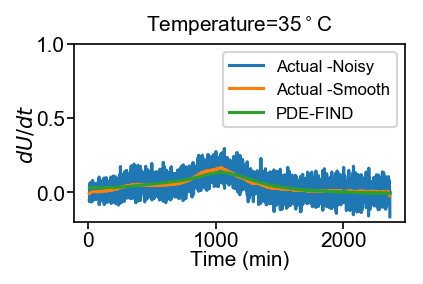

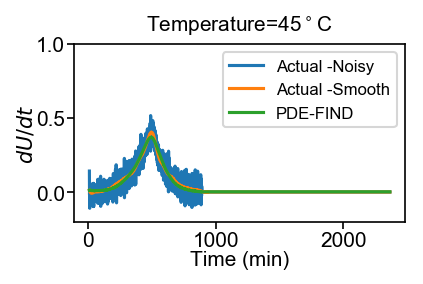

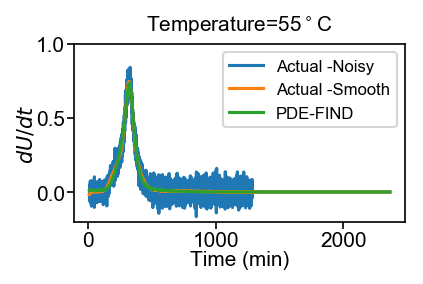

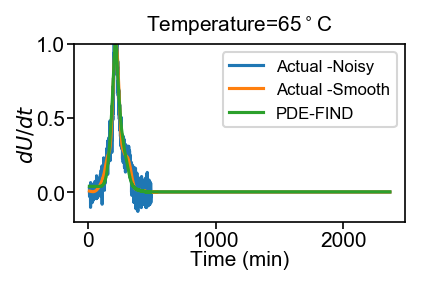

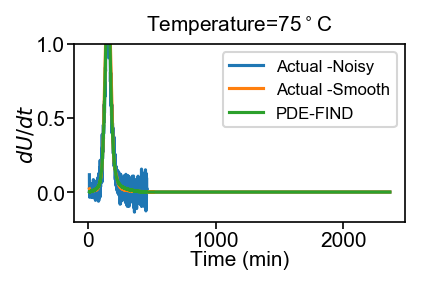

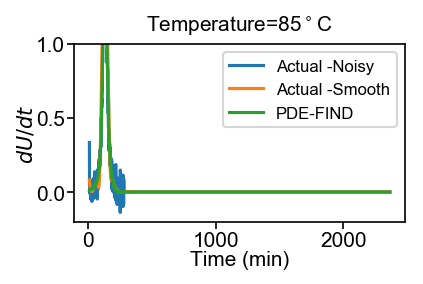

In [17]:
###--- comparing the actual derivative with PDE-FIND estimate ---###

mae_alld = [] # vector to store the MAE between actual derivative and PDE-FIND estimate

for i in range(len(T)):
    fig, ax = plt.subplots(1, 1, figsize = (3,2), dpi=150)
    ax.tick_params(axis='both', which='major', pad=1)
    plt.title("Temperature="+str(T[i]) + "$^\circ$C", fontsize = 10)
    
    # estimate actual derivative through PDE-FIND
    pde_data = np.tile(rml[i][:],(1,1))
    Ut_actual,_,_ = build_linear_system(pde_data, dt, dx, D=D0, P=P0, time_diff = method, space_diff = method)
    
    # First, the actual derivative needs to be smoothened. we use the savitzky-golay filter
    Ut_smooth = scipy.signal.savgol_filter(Ut_actual.reshape((-1)), 235, 5) 
    
    # PDE-FIND estimate
    Ut_pdefind = pdediffeq(rml[i], time, solavg[i])
    
    
    plt.plot(time[:],Ut_actual[:], label = 'Actual -Noisy')
    plt.plot(time[:], Ut_smooth[:], label = 'Actual -Smooth')
    plt.plot(time[:], Ut_pdefind[:], label = 'PDE-FIND')
    
    plt.xlabel("Time (min)", fontsize = 10, labelpad = 0)
    plt.ylabel("$dU/dt$", fontsize = 10, labelpad = 0)
    plt.ylim(-0.2,1)
    plt.legend(fontsize = 8)
    
    # calculate MAE error
    mae_alld.append(mae(Ut_smooth,Ut_pdefind))
    
    plt.tight_layout()

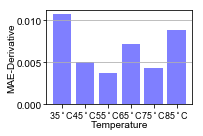

In [18]:
###--- bar-plot :comparing the actual derivative with PDE-FIND estimate ---###

fig, ax = plt.subplots(1, 1, figsize = (3,2))
ax.tick_params(axis='both', which='major', pad=1)
plt.bar(range(len(T)),np.divide(mae_alld,1),
        width = 0.8,
        color = 'b',
        align ='center',
        alpha=0.5,
        ecolor='black',
        capsize=14)

ax.set_ylabel('MAE-Derivative', fontsize = 10, labelpad = 0)
ax.set_xlabel('Temperature', fontsize = 10, labelpad = 0)

ax.set_xticks(range(len(T)))
ax.set_xticklabels([str(T[i])+'$^\circ$C' for i in range(len(T))], fontsize = 9)
ax.set_title('')
ax.yaxis.grid(True)
plt.tight_layout()

### Plot Integrated equation

c:\users\richa\anaconda3\envs\pdefind\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


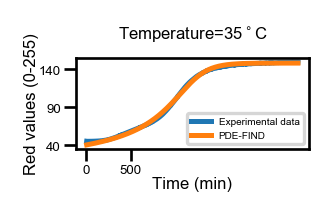

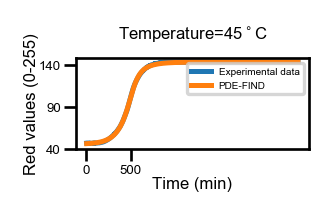

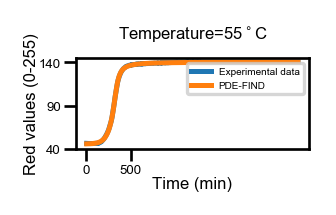

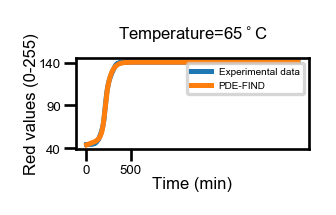

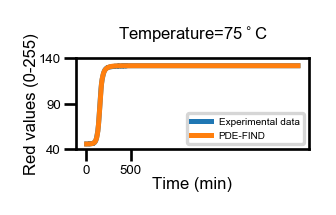

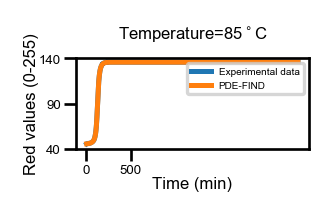

In [16]:
mae_alli = [] # vector to store the MAE between actual data and PDE-FIND estimate integrated curve

for i in range(len(T)):
    fig, ax = plt.subplots(1, 1, figsize = (1.5,1), dpi = 240)
    ax.tick_params(axis='both', which='major', pad=1)
    
    # integrate PDE-FIND equation with odeint
    U0 = bestUo(pdediffeq, solavg, time, i) # inital conditions at t=0
    curve = np.reshape(odeint(pdediffeq, U0, np.reshape(time,(-1)), args=(solavg[i],), atol = atol0, rtol = rtol0), (len(time)))

    plt.title("Temperature="+str(T[i])+ "$^\circ$C", fontsize = 5)
    plt.plot(time[:],rml[i][:], label = "Experimental data")
    plt.plot(time[:],curve[:], label="PDE-FIND")
    plt.ylabel("Red values (0-255)", fontsize = 5, labelpad = 0)
    plt.xlabel("Time (min)", fontsize = 5, labelpad = 0)
    plt.legend(fontsize = 3)
    plt.yticks([40,90,140], fontsize = 4)
    plt.xticks([0,500], fontsize = 4)
    
    mae_alli.append(mae(rml[i],curve))
    
    plt.tight_layout()

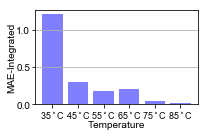

In [19]:
###--- bar-plot: comparing the actual data with PDE-FIND's estimate of integrated curve ---###

fig, ax = plt.subplots(1, 1, figsize = (3,2))
ax.tick_params(axis='both', which='major', pad=1)
plt.bar(range(len(T)),np.divide(mae_alli,1),
        width = 0.8,
        color = 'b',
        align ='center',
        alpha=0.5,
        ecolor='black',
        capsize=14)

ax.set_ylabel('MAE-Integrated', fontsize = 10, labelpad = 0)
ax.set_xlabel('Temperature', fontsize = 10, labelpad = 0)

ax.set_xticks(range(len(T)))
ax.set_xticklabels([str(T[i])+'$^\circ$C' for i in range(len(T))], fontsize = 9)
ax.set_title('')
ax.yaxis.grid(True)
plt.tight_layout()